In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt

import util

In [3]:
dsets = util.open_cmip_cached(
    operator_applied="regional_integral", 
    region_mask="SET_NET",
)
ds = dsets['historical.Omon.SET_NET.regional_integral']
ds


--> The keys in the returned dictionary of datasets are constructed as follows:
	'experiment_id.table_id.region_mask.operator_applied'


<xarray.Dataset>
Dimensions:       (source_id: 13, region: 2, month: 12)
Coordinates:
  * source_id     (source_id) <U15 'ACCESS-ESM1-5' 'CESM2' ... 'UKESM1-0-LL'
  * month         (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * region        (region) <U3 'NET' 'SET'
Data variables:
    epc100        (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fbddtdic      (source_id, region, month) float32 dask.array<chunksize=(5, 2, 12), meta=np.ndarray>
    fgapo         (source_id, region, month) float32 dask.array<chunksize=(2, 2, 12), meta=np.ndarray>
    fgco2         (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgn2          (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    fgo2          (source_id, region, month) float32 dask.array<chunksize=(2, 2, 12), meta=np.ndarray>
    fgo2_thermal  (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    hfds          (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    intpp         (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    sos           (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
    tos           (source_id, region, month) float32 dask.array<chunksize=(1, 2, 12), meta=np.ndarray>
Attributes:
    intake_esm_varname:      epc100\nfbddtdic\nfgapo\nfgco2\nfgn2\nfgo2\nfgo2...
    intake_esm_dataset_key:  historical.Omon.SET_NET.regional_integral

## Make some plots

In [6]:
monlabs = np.array(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])

In [7]:
# define function to plot 4 variables (columns) by 2 regions (rows)

def plot4var2reg(variable_ids):

    nrows = 2
    ncols = len(variable_ids)
    
    #ncols = 4
    #nrows = np.ceil(len(variable_ids)*len(ds.region.values)/ncols).astype(int)
    #for region, field, ax in zip(np.repeat(ds.region.values,len(variable_ids)), variable_ids*len(ds.region.values), axs.ravel()):

    fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 7*nrows), facecolor='w', sharex=True) # , sharey=True)

    for field, region, ax in zip(variable_ids*len(ds.region.values),np.repeat(ds.region.values,len(variable_ids)), axs.ravel()):
        for source_id in ds.source_id.values:
            ax.plot(
                ds.month-0.5, 
                ds[field].sel(source_id=source_id, region=region), 
                marker='.', 
                linestyle='-',
                label=source_id,
            )

        ax.set_xticks(np.arange(13))    
        ax.set_ylabel(f"{ds[field].attrs['long_name']} [{ds[field].attrs['units']}]")
        ax.set_title(region);
        ax.set_xticklabels([])
        ax.set_xticklabels([f'        {m}' for m in monlabs]+[''])
    ax.legend(loc=(1.02, 0));

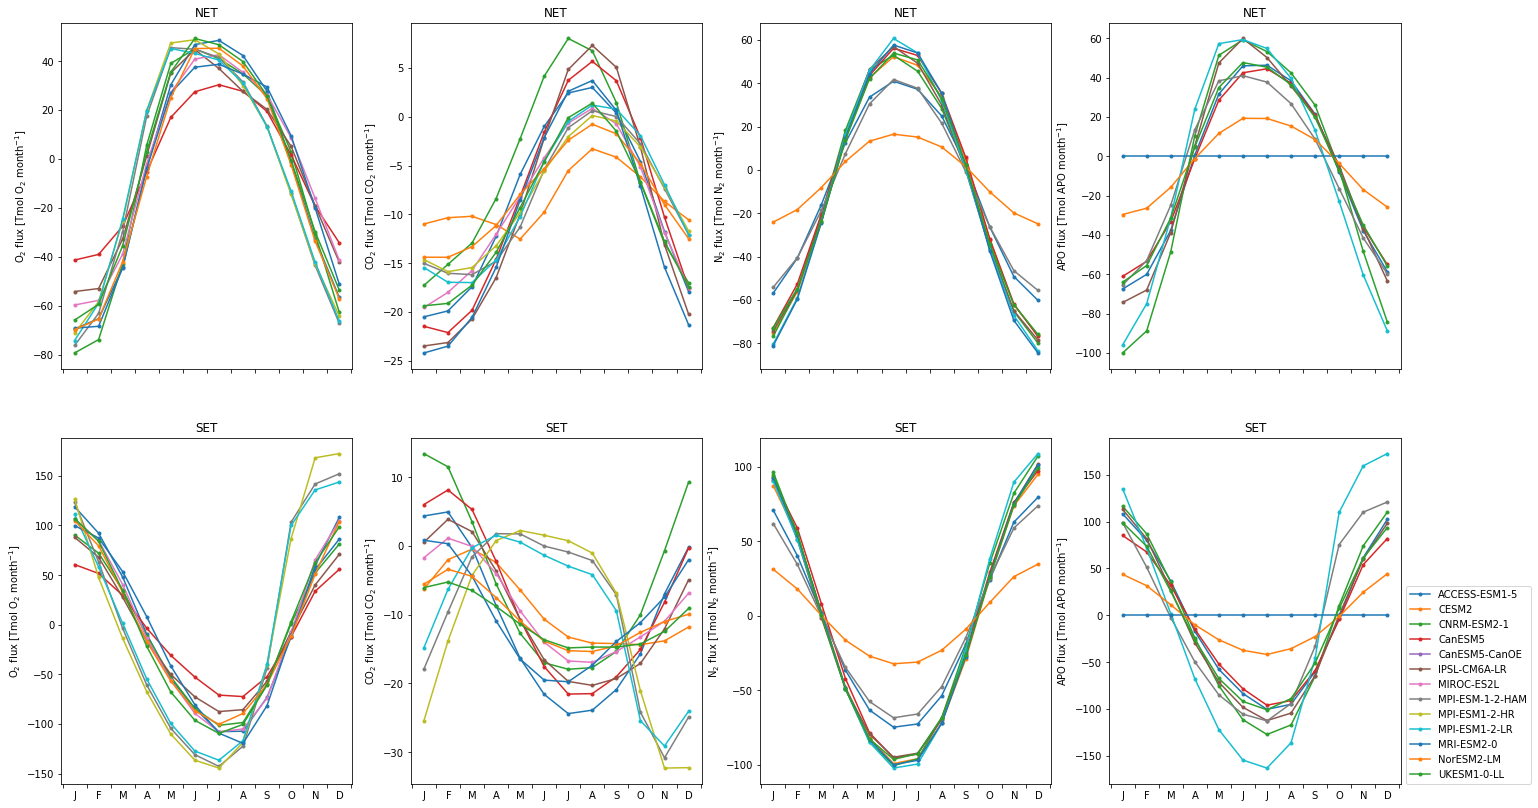

In [8]:
variable_ids = ['fgo2','fgco2','fgn2','fgapo']
plot4var2reg(variable_ids)

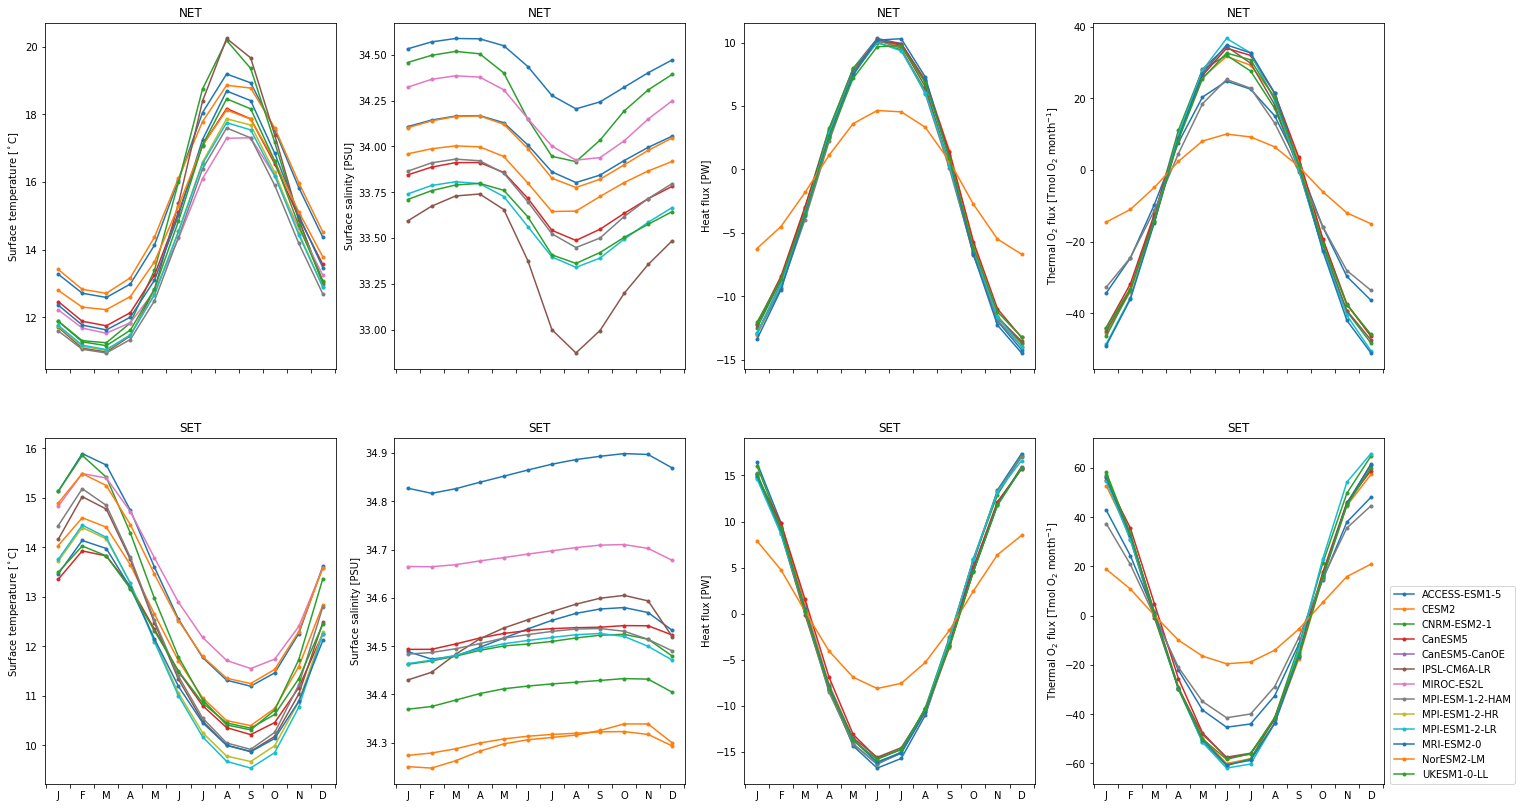

In [9]:
variable_ids = [ 'tos', 'sos', 'hfds','fgo2_thermal' ]
plot4var2reg(variable_ids)

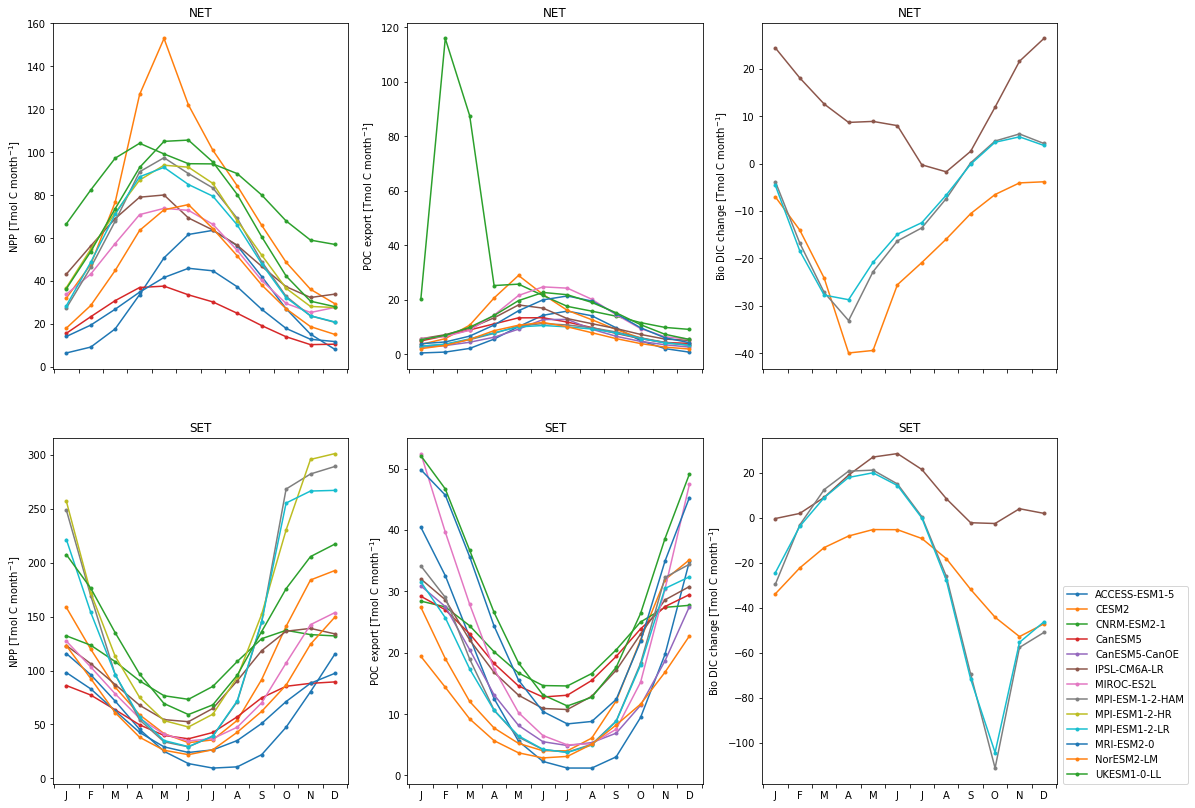

In [10]:
variable_ids = [ 'intpp', 'epc100', 'fbddtdic']
plot4var2reg(variable_ids)

## Test SNO calculations

In [11]:
# defining SNO here as the seasonal component of the O2 (or APO for SNOapo) flux
# specifically the integral of positive flux values after subtracting the annual mean
# (or the amplitude of the time-integrated flux cycle)
# this is to match the observed APO cycle in the atmosphere which has an arbitrary mean (i.e. it is agnostic to annual mean fluxes)

source_id='CanESM5'
region='SET'

# first remove the annual mean
ds['fgo2seas'] = ds['fgo2'].sel(source_id=source_id, region=region)-ds['fgo2'].sel(source_id=source_id, region=region).mean()

# then sum positive values
ds['sno']=sum(x for x in ds['fgo2seas'] if x > 0)
ds['sno'].values # 259.56

array(259.5582, dtype=float32)

In [12]:
# alternately calculate time integral
ds['fgo2cum'] = ds['fgo2seas'].cumsum()
# then find the amplitude
ds['sno'] = ds['fgo2cum'].max() - ds['fgo2cum'].min()
ds['sno'].values # 259.56

array(259.5582, dtype=float32)

In [13]:
# get a slightly different value if we interpolate to daily resolution first
tmp=np.interp(np.arange(0,366)/365*12,ds['fgo2seas'].month-0.5,ds['fgo2seas'],period=12)
sum(x for x in tmp if x > 0)*12/365 # 257.90

257.89941798397166